# MBTI PREDICTION

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

In [2]:
#데이터 불러오기
df = pd.read_csv('MBTI_train.csv',header=None)
test = pd.read_csv('MBTI_test.csv',header=None)

# 데이터 전처리

In [3]:
df.head()

,0,1
0,INTP,say process model list like subscriber channel...
1,INFJ,upon much manipulate retail finish like sacrif...
2,INFJ,fit yes certain bff social feel goal go know n...
3,INTJ,complete love within someone ideal joke solvea...
4,ENTJ,public strictly thing person x question person...


In [4]:
# 열이름 지정
df.columns=['type','text']
test.columns=['text']

In [5]:
df.head()

,type,text
0,INTP,say process model list like subscriber channel...
1,INFJ,upon much manipulate retail finish like sacrif...
2,INFJ,fit yes certain bff social feel goal go know n...
3,INTJ,complete love within someone ideal joke solvea...
4,ENTJ,public strictly thing person x question person...


### 데이터 확인

결측값 확인 및 데이터 개수 확인하여 전처리 진행

In [6]:
#데이터 개수 확인
df.shape, test.shape

((74357, 2), (9337, 1))

train 데이터의 개수는 74357개, test 데이터의 개수는 9337개가 존재함.

In [7]:
#결측값 확인
df.text.isnull().sum()

0

결측값이 없는 것으로 확인됨.

In [8]:
#MBTI별 데이터 개수
df['type'].value_counts()

INTP    17690
INTJ    16079
INFJ    10765
INFP     8444
ENTP     8303
ENFP     4338
ISTP     2394
ENTJ     2106
ENFJ     1024
ISTJ      878
ESTP      814
ISFP      620
ISFJ      460
ESFP      252
ESFJ      119
ESTJ       71
Name: type, dtype: int64

<AxesSubplot:>

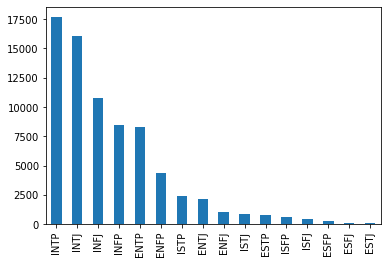

In [9]:
df['type'].value_counts().plot(kind='bar')

In [10]:
#정확도 계산 함수 생성
def accur(y, pred) :
    accuracy = accuracy_score(y, pred)*100
    print(f'정확도:{accuracy:.3f}')

In [11]:
#train 데이터에서 text부분과 mbti부분으로 구분
X=df['text']
y=df['type']

### 텍스트 전처리

In [12]:
X[0]

'say process model list like subscriber channel region act position since without hear resus help study sense external specialize movement dude thousand yes even get essential part road involve expressiveness like factor never probably le non think dedicate medium task take brain oh architectural would diagnose technology college precisely fi understand dominant dom security run make hard tribe lot stop opinion bad washinon solely best extremely sound since patreon back differently mean differ cia high discrimination make two si holistic though passage would make director continue else task enigma question yet whatever field probably mean part arbitrary hedonism ask post find broaden matter read lot sql essential cuure start language think month demand intp plz like like without exam help get system something einstein though would stream create personal sort relative would k would language k man flat example without typically learn read still teach problem split function mean long ment

첫 번째 데이터를 확인해보면, 어간이 추출 되어 있다.
또한, fi, k, u 와 같이 길이가 짧은 단어는 큰 의미를 담고 있지 않는 것으로 보여 사전에 제거를 함.

### 짧은 단어 정리

정규표현식을 활용하여 길이가 1~2인 단어는 제거

In [13]:
#길이가 1~2인 단어 정리
shortword = re.compile(r'\W*\b\w{1,2}\b')
for i in tqdm(range(len(X))):
    X[i]=shortword.sub('', X[i])

100%|████████████████████████████████████| 74357/74357 [02:28<00:00, 499.38it/s]


In [14]:
c=[]
for i in tqdm(range(len(X))):
    a=len(X[i].split(' '))
    c.append(a)

sum(c)/len(X)

100%|██████████████████████████████████| 74357/74357 [00:02<00:00, 28169.75it/s]


387.33969901959466

데이터의 개수가 400개에서 평균 387개로 줄어든 것을 확인할 수 있음.

### stemming

In [15]:
X_stem=X.copy()
stem = PorterStemmer()
for i in tqdm(range(len(X))):
    X_stem[i]=stem.stem(X[i])

100%|███████████████████████████████████| 74357/74357 [00:52<00:00, 1411.99it/s]


어간이 어느정도 추출되어있는 것으로 보이나, X_stem으로 stemming한 text를 저장하여 추후에 정확도를 비교해보기로 함.

# train 데이터 나누기

모수를 설정하는 데 사용하기 위하여 train 데이터를 train data와 valid data로 cross validation을 진행하고자 함.

In [16]:
X_train, X_valid, y_train, y_valid =train_test_split(X,y, test_size=0.2)
len(X_train),len(X_valid)

(59485, 14872)

0.2의 비율로 나누어 74357개의 데이터를 (59485, 14872)개로 나눔

# 단어 임베딩

- Tf: 하나의 문서에서 특정 단어가 등장하는 빈도 (단어의 빈도수 반영)

- Idf: 특정 단어가 몇 개의 text에서 등장하는 횟수의 역수 (단어의 특이성 반영)

Tf*IDF인 TF-IDF를 이용하여 text 데이터를 수치로 표현함

In [17]:
tf=TfidfVectorizer()
X_train_tfidf=tf.fit_transform(X_train)
X_valid_tfidf=tf.transform(X_valid)

In [18]:
X_train_tfidf.shape, X_valid_tfidf.shape

((59485, 152127), (14872, 152127))

# 모델 선정

분류 모델 중 LogisticRegression, LinearSVC, RandomForestClassifier, KNN, RidgeClassifier 을 이용하여 정확도를 계산함.

In [19]:
clf1=LogisticRegression()
clf2=LinearSVC()
clf3=RandomForestClassifier()
clf4=KNN()
clf5=RidgeClassifier()

In [20]:
clf1.fit(X_train_tfidf, y_train)
clf2.fit(X_train_tfidf, y_train)
clf3.fit(X_train_tfidf, y_train)
clf4.fit(X_train_tfidf, y_train)
clf5.fit(X_train_tfidf, y_train)

clf1_pred=clf1.predict(X_valid_tfidf)
clf2_pred=clf2.predict(X_valid_tfidf)
clf3_pred=clf3.predict(X_valid_tfidf)
clf4_pred=clf4.predict(X_valid_tfidf)
clf5_pred=clf5.predict(X_valid_tfidf)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
accur(y_valid, clf1_pred)
accur(y_valid, clf2_pred)
accur(y_valid, clf3_pred)
accur(y_valid, clf4_pred)
accur(y_valid, clf5_pred)

정확도:78.604
정확도:79.216
정확도:46.947
정확도:39.060
정확도:77.925


LinearSVC, LogisticRegression, RidgeClassifier 순으로 정확도가 높으므로, LinearSVC를 사용하기로 함.

### 파이프라인 구축

In [22]:
X_train, X_valid, y_train, y_valid =train_test_split(X,y, test_size=0.2,random_state=42)

text_clf=Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC(random_state=42))])
text_clf.fit(X_train,y_train)
pred=text_clf.predict(X_valid)
accur(y_valid, pred)

정확도:78.436


In [23]:
#위에서 정리한 X_stem의 정확도 확인
X_train_stem, X_valid_stem, y_train_stem, y_valid_stem=train_test_split(X_stem,y, test_size=0.2, random_state=42)

text_clf_stem=Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC(random_state=42))])
text_clf_stem.fit(X_train_stem,y_train_stem)
pred_stem=text_clf_stem.predict(X_valid_stem)
accur(y_valid_stem, pred_stem)

정확도:78.389


원 데이터와 비교하여 X_stem 데이터의 정확도가 더 낮으므로 stemming 효과 없음

### 하이퍼 파라미터 튜닝

규제의 강도를 설정하는 C를 조절하여 하이퍼 파라미터를 설정함.
 - C 값이 작으면 잘못 분류되는 데이터가 있더라도 마진을 최대로 함.
 - C 값이 크면 마진이 작아지더라도 잘못 분류되는 데이터가 적어지도록 함.

In [24]:
#정확도 기준
clf=LinearSVC()
cv=GridSearchCV(clf, {'C':[0.1,0.2,0.3,0.5,1.0]}, scoring='accuracy')

text_clf=Pipeline([('tfidf',TfidfVectorizer()),('clf',cv)])
text_clf.fit(X_train,y_train)

print(cv.best_estimator_.C)

0.3


C=0.3이 최적의 파라미터 이므로 0.3으로 설정하여 모델링 함.

In [25]:
text_clf=Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC(C=0.3, random_state=42))])
text_clf.fit(X_train,y_train)
pred=text_clf.predict(X_valid)
accur(y_valid, pred)

정확도:79.061


0.3으로 했을 때 정확도가 소폭 상승한 것을 확인할 수 있다.

> **IDEA**

MBTI는 4개의 지표가 독립적으로 이루어진 것이기에 각각의 문자를 모델링 하면 더 정확도가 오를 것이라 생각함.

In [44]:
clf=LinearSVC()
cv=GridSearchCV(clf, {'C':[0.1,0.2,0.3,0.4,0.5]}, scoring='accuracy')

for i in range(4):
    text_clf_each=Pipeline([('tfidf',TfidfVectorizer()),('clf',cv)])
    text_clf_each.fit(X_train,y_train.str[i])
    print(cv.best_estimator_.C)

0.4
0.5
0.2
0.2


각 지표별로 최적의 C값을 찾았을 때 0.4, 0.5, 0.2, 0.2 로 나옴

In [46]:
#i/e
text_clf0=Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC(C=0.4, random_state=42))])
text_clf0.fit(X_train,y_train.str[0])
pred0=text_clf0.predict(X_valid)

#s/n
text_clf1=Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC(C=0.5, random_state=42))])
text_clf1.fit(X_train,y_train.str[1])
pred1=text_clf1.predict(X_valid)

#t/f
text_clf2=Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC(C=0.2, random_state=42))])
text_clf2.fit(X_train,y_train.str[2])
pred2=text_clf2.predict(X_valid)

#p/j
text_clf2.fit(X_train,y_train.str[3])
pred3=text_clf2.predict(X_valid)

In [47]:
accur(y_valid.str[0], pred0)
accur(y_valid.str[1], pred1)
accur(y_valid.str[2], pred2)
accur(y_valid.str[3], pred3)

정확도:89.329
정확도:95.636
정확도:91.588
정확도:84.649


In [29]:
accur(y_valid.str[0], pd.DataFrame(pred)[0].str[0])
accur(y_valid.str[1], pd.DataFrame(pred)[0].str[1])
accur(y_valid.str[2], pd.DataFrame(pred)[0].str[2])
accur(y_valid.str[3], pd.DataFrame(pred)[0].str[3])

정확도:92.113
정확도:96.147
정확도:91.608
정확도:87.702


원래 모델의 각 성분과 비교하여도 정확도가 낮으므로 각각으로 고려하는 것 보다는 전체 MBTI를 데이터로 다루는 것이 더 효율적임.

각 성분간에 상호작용이 있어서 MBTI별 특징이 생기는 것으로 판단함.

# predict

최종적으로, test 데이터를 예측함.

In [53]:
test_data=test['text']
for i in tqdm(range(len(test_data))):
    test_data[i]=shortword.sub('', test_data[i])
prediction=text_clf.predict(test_data['text'])

In [56]:
prediction

array(['ENFP', 'ENTP', 'INTJ', ..., 'INTP', 'ENFP', 'INFP'], dtype=object)